In [1]:
from src.load_data import create_data_block

In [2]:
from pytorch_lightning.utilities.warnings import PossibleUserWarning
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=PossibleUserWarning)

In [3]:
OUTPUT_DATA = "../../out_data/"
INPUT_DATA = "../../input_data/"

In [4]:
data_block = create_data_block(INPUT_DATA, OUTPUT_DATA, debug = False)

Diario: {'texto': 'LA VOZ', 'bounding_box': {'x': 35, 'y': 105, 'width': 153, 'height': 48}}
Diario: {}
Archivo: ../../input_data/La razón 1985-05-17 Los procesados podrían alegar legítima defensa.json | Segmento: Diario  | Estado ERROR no key/value:'bounding_box'!
Archivo: ../../input_data/La razón 1985-05-17 Los procesados podrían alegar legítima defensa.json | Segmento: Fecha  | Estado ERROR no key/value:'bounding_box'!
Diario: {'texto': 'TIEMPO ARGENTINO', 'bounding_box': {'x': 184, 'y': 66, 'width': 458, 'height': 41}}
Diario: {'texto': 'EL PAÍS', 'bounding_box': {'x': 886, 'y': 207, 'width': 362, 'height': 39}}
Archivo: ../../input_data/Pag. 12 1990-01-06 Encuentran los cuerpos....json | Segmento: Fecha  | Estado ERROR no key/value:'bounding_box'!
Diario: {'texto': 'TIEMPO ARGENTINO', 'bounding_box': {'x': 963, 'y': 288, 'width': 386, 'height': 30}}
Diario: {'texto': 'Crónica', 'bounding_box': {'x': 2351, 'y': 412, 'width': 40, 'height': 115}}
Diario: {'texto': 'TIEMPO ARGENTINO'

In [5]:
len(data_block)

50

In [6]:
train = data_block[:40]
val = data_block[40:45]
test = data_block[45:]
print(f'Train: {len(train)} \nVal: {len(val)}\nTest: {len(test)}')

Train: 40 
Val: 5
Test: 5


In [7]:
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from typing import Iterator, Union, Iterable
from more_itertools import flatten, unique_everseen


NODE_FEATURES = [
    "n_line",
    "x_position",
    "y_position",
    "box_area",
]

def get_node_features(token_box: dict):
    node_features = [
        v if isinstance(v, Iterable) else [v]
        for k, v in token_box.items()
        if k in NODE_FEATURES
    ]

    assert len(NODE_FEATURES) == len(node_features), (
        "mismatch in the number of node features ",
        f"expected => {len(NODE_FEATURES)} ",
        f"current  => {len(node_features)}",
    )

    node_features = list(flatten(node_features))
    return node_features


def get_labels(datablock) -> Iterator[str]:
    labels = (
        (token["label"] for token in data_item["token_boxes"])
        for data_item in datablock
    )

    labels = flatten(labels)
    return labels

def set_label_map(datablock):
    labels = unique_everseen(get_labels(datablock))

    label_map = {
        label : idx
        for idx, label in enumerate(labels)
    }

    inv_label_map = {v: k for k, v in label_map.items()}
    
    return label_map, inv_label_map


def get_doc_graph(data_item) -> nx.DiGraph:
    label_map, inv_label_map = set_label_map(train)
    data_map = {
        token_box["id"]: {
            "node_features": get_node_features(token_box),
            "label": label_map[token_box["label"]],
        }
        for token_box in data_item["token_boxes"]
    }

    doc_graph = data_item["doc_graph"]
    node_attributes = {
        node: {
            "x": data_map[node]["node_features"],
            "y": data_map[node]["label"],
        }
        for node in doc_graph.nodes
    }

    nx.set_node_attributes(doc_graph, node_attributes)
    return doc_graph

def get_pg_graph(doc_graph: nx.DiGraph) -> Data:
    pg_graph = from_networkx(doc_graph)
    pg_graph.x = pg_graph.x.float()
    pg_graph.y = pg_graph.y.long()
    return pg_graph

def get_pg_graphs(data_block) -> list[Data]:
    doc_graphs = map(get_doc_graph, data_block)
    pg_graph = [get_pg_graph(doc_graph) for doc_graph in doc_graphs]

    return pg_graph

In [8]:
label_map, inv_label_map = set_label_map(train)

In [9]:
pg_graph_train = get_pg_graphs(train)
pg_graph_val = get_pg_graphs(val)

In [10]:
n_features = pg_graph_train[0].x.shape[1]
n_features

4

In [11]:
n_classes = len(label_map)
n_classes

12

In [12]:
hidden_channels = 512

In [13]:
from torch import nn
from torch_geometric.nn import SAGEConv
from torch.nn import CrossEntropyLoss
from torchmetrics import F1Score
from torch.optim import Adam

from pytorch_lightning import LightningModule
from torch_geometric.loader import DataLoader
import torch
from torch.optim import Optimizer

class Model(LightningModule):
    def __init__(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        hidden_channels: int,
        n_features: int,
        n_classes: int,
    ):
        super().__init__()

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.lin1 = nn.Linear(512, n_features // 2)
        self.sig1 = nn.Sigmoid()

        self.sage_conv1 = SAGEConv(
            n_features,
            hidden_channels,
            aggr="mean",
        )

        self.sage_conv2 = SAGEConv(hidden_channels, n_classes, aggr="mean")

        self.ce_loss = CrossEntropyLoss()
        self.f1 = F1Score('multiclass', num_classes = n_classes, top_k=1, average="macro")

    
    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:

        x = self.sage_conv1(x, edge_index)
        x = x.relu()

        x = self.sage_conv2(x, edge_index)
        return x

    def training_step(
        self, batch: torch.Tensor, batch_index: torch.Tensor
    ) -> torch.Tensor:

        x, edge_index = (
            batch.x,
            batch.edge_index,
        )

        x_out = self.forward(x, edge_index)
        loss = self.ce_loss(x_out, batch.y)

        preds = x_out.argmax(dim=1)
        self.f1(preds, batch.y)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_f1", self.f1, prog_bar=True)

        return loss

    def validation_step(self, batch: torch.Tensor, batch_idx: torch.Tensor):
        """
        When the validation_step() is called,
        the model has been put in eval mode
        and PyTorch gradients have been disabled.
        At the end of validation, the model goes back to training mode
        and gradients are enabled.
        """

        x, edge_index = (
            batch.x,
            batch.edge_index,
        )

        x_out = self.forward(x,edge_index)
        loss = self.ce_loss(x_out, batch.y)

        preds = x_out.argmax(dim=1)
        self.f1(preds, batch.y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", self.f1, prog_bar=True)

    def predict_step(
        self, batch: torch.Tensor, batch_idx: torch.Tensor
    ) -> list:

        x, edge_index = (
            batch.x,
            batch.edge_index,
        )
        pred = self(x, edge_index)

        pred = pred.softmax(dim=1)
        confidences = pred.max(dim=1)
        pred = pred.argmax(dim=1)

        return pred, confidences

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def configure_optimizers(self) -> Optimizer:
        optimizer = Adam(self.parameters(), lr=0.0005)
        return optimizer

In [14]:
train_loader = DataLoader(
    pg_graph_train, batch_size=32, shuffle=False, num_workers = 16
)

val_loader = DataLoader(
    pg_graph_val, batch_size=32, shuffle=False, num_workers = 16
)

model = Model(
    train_loader, 
    val_loader,
    hidden_channels= hidden_channels,
    n_features= n_features,
    n_classes= n_classes
)

In [15]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


train_monitor = "loss"
es_patience = 100

MONITOR_MAP = {
    "f1":  {
        "monitor": "val_f1",
        "mode": "max",
    },
    "loss":  {
        "monitor": "val_loss",
        "mode": "min",
    }
}

monitor = MONITOR_MAP[train_monitor]["monitor"]
mode = MONITOR_MAP[train_monitor]["mode"]

early_stop_callback = EarlyStopping(
    monitor=monitor,
    mode=mode,
    min_delta=0.00,
    patience= es_patience,
    verbose=False,
)

trainer = Trainer(
    max_epochs= 1000,
    callbacks=[
        early_stop_callback,
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | lin1       | Linear            | 1.0 K 
1 | sig1       | Sigmoid           | 0     
2 | sage_conv1 | SAGEConv          | 4.6 K 
3 | sage_conv2 | SAGEConv          | 12.3 K
4 | ce_loss    | CrossEntropyLoss  | 0     
5 | f1         | MulticlassF1Score | 0     
-------------------------------------------------
17.9 K    Trainable params
0         Non-trainable params
17.9 K    Total params
0.072     Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.01it/s, v_num=6, train_loss=361.0, train_f1=0.00144]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.49it/s, v_num=6, train_loss=64.50, train_f1=0.0875, val_loss=56.00, val_f1=0.0134]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.55it/s, v_num=6, train_loss=62.40, train_f1=0.0885, val_loss=49.20, val_f1=0.0853]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.60it/s, v_num=6, train_loss=43.70, train_f1=0.123, val_loss=32.00, val_f1=0.0959]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.42it/s, v_num=6, train_loss=40.90, train_f1=0.164, val_loss=26.40, val_f1=0.115]
V

## Predict

In [64]:
test_pg_graphs = get_pg_graphs(test)
test_loader = DataLoader(
    pg_graphs, batch_size=3, shuffle=False
)

In [65]:
import numpy as np
from copy import deepcopy


def data_item_predict(data_item, pred_map: dict):

    data_item = deepcopy(data_item)
    data_item["token_boxes"] = [
        token_box | pred_map[token_box["id"]]
        for token_box in data_item["token_boxes"]
    ]
    return data_item

def predict(data_block):
    pg_graphs = get_pg_graphs(data_block)

    loader = DataLoader(
        pg_graphs, batch_size=5, shuffle=False
    )

    pred_tuples = trainer.predict(model, loader)
    preds = [pred[0].cpu().numpy() for pred in pred_tuples]
    confidences = [pred[1][0].cpu().numpy() for pred in pred_tuples]

    preds = np.hstack(preds)
    confidences = np.hstack(confidences)
    
    label_map, inv_label_map = set_label_map(train)

    pred_labels = (inv_label_map[label_idx] for label_idx in preds)
    node_ids = (
        (token_box["id"] for token_box in data["token_boxes"])
        for data in data_block
    )

    node_ids = flatten(node_ids)
    pred_map = {
        idx: {"pred_label": pred_label, "cls_conf": conf}
        for idx, pred_label, conf in zip(
            node_ids, pred_labels, confidences
        )
    }

    data_block = [
        data_item_predict(data_item, pred_map)
        for data_item in data_block
    ]

    return data_block

In [69]:
pred = predict(test)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 321.72it/s]


In [75]:
y_pred = []
y_true = []
for image in range(len(test)):
    for i in range(len(pred[image]['token_boxes'])):
        y_true.append(pred[image]['token_boxes'][i]['label'])
        y_pred.append(pred[image]['token_boxes'][i]['pred_label'])

In [76]:
len(y_pred) , len(y_true)

(2740, 2740)

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix


def show_metrics(
    y_true: np.array,
    y_pred: np.array,
    inv_label_map: dict,
):

    target_names = [str(i) for i in list(inv_label_map.values())]
    report = classification_report(
        y_true,
        y_pred,
        labels=list(inv_label_map.keys()),
        target_names=target_names,
    )
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    cm = confusion_matrix(y_true, y_pred, normalize="true")

    sns.heatmap(
        cm,
        ax=ax,
        robust=True,
        annot=True,
        square=False,
        xticklabels=target_names,
        yticklabels=target_names,
    )

    ax.set_xlabel("prediction")
    ax.set_ylabel("true")

    plt.show()

/home/romi/Proyects/record_ar_ia/recordar_ia/recordar_ia/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home/romi/Proyects/record_ar_ia/recordar_ia/recordar_ia/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home/romi/Proyects/record_ar_ia/recordar_ia/recordar_ia/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home/romi/Proyects/record_ar_ia/recordar_ia/recordar_ia/lib/python3.10/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will 

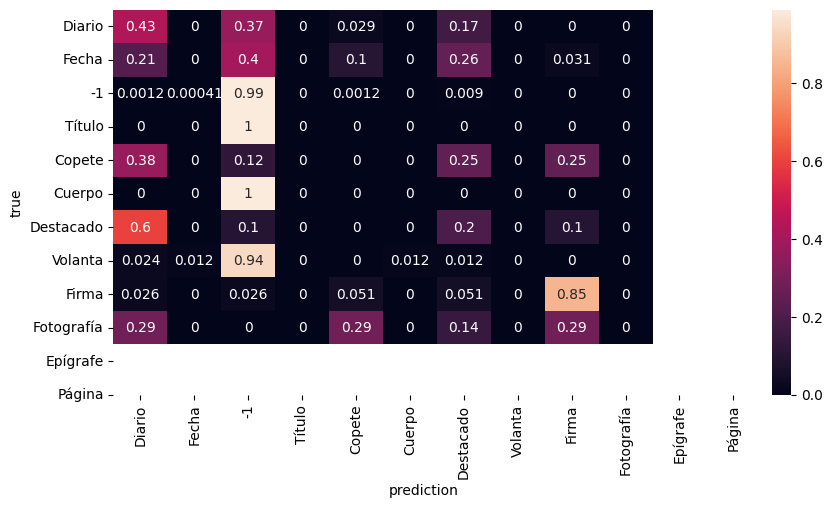

In [83]:
show_metrics(y_true, y_pred, inv_label_map)